# What this notebook does

This notebook plots expression of TGFB1 programs (TGFB1-1 and TGFB1-1) in aberrant and non-aberrant disease states for Fig. 5E.

# Set up

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as pl, scipy.sparse as ssp
import scanpy as sc,scanpy.external as sce
import sys
sys.path.append('../../helper_functions/')
import helper_functions_py3 as hf

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100)  # low dpi (dots per inch) yields small inline figures

import random
import scipy.stats  as ss
import statsmodels.stats.multitest as multitest
from matplotlib.patches import Rectangle
import seaborn as sn

# Load data

## Disease datasets

In [2]:
# load data from all diseases:
# update this with the path where your anndata objects are stored !!

anndata_path = '../../data/anndata_objects/'

# IPF1, GEO ID: GSE135893
adata_ipf1 = sc.read_h5ad(anndata_path + 'adata_ipf1_epithelial_processed.h5ad')

# IPF 2, GEO ID: GSE136831
adata_ipf2 = sc.read_h5ad(anndata_path + 'adata_ipf2_epithelial_processed.h5ad')

# COPD, GEO ID: GSE136831
adata_copd = sc.read_h5ad(anndata_path + 'adata_copd_epithelial_processed.h5ad')

# COVID, GEO ID: GSE171524
adata_covid = sc.read_h5ad(anndata_path +'adata_covid_epithelial_processed.h5ad')

# subset data to only include diseased donors:
adata_ipf1_disease = adata_ipf1[adata_ipf1.obs.Diagnosis != 'Control'].copy()
adata_ipf2_disease = adata_ipf2[adata_ipf2.obs['"Disease_Identity"'] == '"IPF"'].copy()
adata_copd_disease = adata_copd[adata_copd.obs['"Disease_Identity"'] == '"COPD"'].copy()
adata_covid_disease = adata_covid[adata_covid.obs['disease__ontology_label'] == 'COVID-19'].copy()


## cNMF data

In [3]:
# load gene program data, also called the spectra matrix:

# this is gene x programs matrix with a weight for every gene 
# for each of the gene expression programs

cnmf_dir = '../../data/cnmf/'
spectra = pd.read_csv(cnmf_dir+'program_weights.csv', sep=',', index_col=0).T


In [4]:
# subset genes to only include the ones in disease dataset:

# ipf1:
gene_subset_mask_ipf1 = np.in1d(spectra.columns, adata_ipf1.var_names)
spectra_subset_ipf1 = spectra[spectra.columns[gene_subset_mask_ipf1]]

# ipf2:
gene_subset_mask_ipf2 = np.in1d(spectra.columns, adata_ipf2.var_names)
spectra_subset_ipf2 = spectra[spectra.columns[gene_subset_mask_ipf2]]

# copd:
gene_subset_mask_copd = np.in1d(spectra.columns, adata_copd.var_names)
spectra_subset_copd = spectra[spectra.columns[gene_subset_mask_copd]]

# covid:
gene_subset_mask_covid = np.in1d(spectra.columns, adata_covid.var_names)
spectra_subset_covid = spectra[spectra.columns[gene_subset_mask_covid]]


In [5]:
# re-normalize spectra since some of the genes were removed:

# ipf1:
spectra_subset_new_ipf1 = pd.DataFrame(np.array(spectra_subset_ipf1)/np.array(spectra_subset_ipf1.sum(1))[:,np.newaxis])
spectra_subset_new_ipf1.columns = spectra_subset_ipf1.columns
spectra_subset_new_ipf1.index = spectra_subset_ipf1.index

# ipf2:
spectra_subset_new_ipf2 = pd.DataFrame(np.array(spectra_subset_ipf2)/np.array(spectra_subset_ipf2.sum(1))[:,np.newaxis])
spectra_subset_new_ipf2.columns = spectra_subset_ipf2.columns
spectra_subset_new_ipf2.index = spectra_subset_ipf2.index

# copd:
spectra_subset_new_copd = pd.DataFrame(np.array(spectra_subset_copd)/np.array(spectra_subset_copd.sum(1))[:,np.newaxis])
spectra_subset_new_copd.columns = spectra_subset_copd.columns
spectra_subset_new_copd.index = spectra_subset_copd.index

# covid:
spectra_subset_new_covid = pd.DataFrame(np.array(spectra_subset_covid)/np.array(spectra_subset_covid.sum(1))[:,np.newaxis])
spectra_subset_new_covid.columns = spectra_subset_covid.columns
spectra_subset_new_covid.index = spectra_subset_covid.index


# Find expression of TGFB1 programs in aberrant vs rest of the states

## Make matrix of gene for every program


In [6]:
# Make matrix of gene for every program

num_genes = 20
prog_names = np.array(['TGFB1-1', 'TGFB1-2'])

# ipf1:
prog_genes_ipf1 = np.zeros((num_genes, prog_names.shape[0]), dtype = object)

for i,programs in enumerate(prog_names):
    prog_genes_ipf1[:,i] = np.array(spectra_subset_ipf1.loc[programs].sort_values(ascending = False).index[:num_genes])

prog_genes_ipf1_pd = pd.DataFrame(prog_genes_ipf1)
prog_genes_ipf1_pd.columns = prog_names

# ipf2:
prog_genes_ipf2 = np.zeros((num_genes, prog_names.shape[0]), dtype = object)

for i,programs in enumerate(prog_names):
    prog_genes_ipf2[:,i] = np.array(spectra_subset_ipf2.loc[programs].sort_values(ascending = False).index[:num_genes])

prog_genes_ipf2_pd = pd.DataFrame(prog_genes_ipf2)
prog_genes_ipf2_pd.columns = prog_names

# copd:
prog_genes_copd = np.zeros((num_genes, prog_names.shape[0]), dtype = object)

for i,programs in enumerate(prog_names):
    prog_genes_copd[:,i] = np.array(spectra_subset_copd.loc[programs].sort_values(ascending = False).index[:num_genes])

prog_genes_copd_pd = pd.DataFrame(prog_genes_copd)
prog_genes_copd_pd.columns = prog_names

# covid:
prog_genes_covid = np.zeros((num_genes, prog_names.shape[0]), dtype = object)

for i,programs in enumerate(prog_names):
    prog_genes_covid[:,i] = np.array(spectra_subset_covid.loc[programs].sort_values(ascending = False).index[:num_genes])

prog_genes_covid_pd = pd.DataFrame(prog_genes_covid)
prog_genes_covid_pd.columns = prog_names

## Find expression of TGFB1-1 and TGFB1-2 programs

In [7]:
# function to find expression of program in a cell with the given gene list:

def program_expr_cp10k(adata, spectra, gene_list, program ):
    
    # subset expression for the gene list
    
    E = adata[:,gene_list].copy().layers['raw_counts']
    
    if ssp.issparse == True:
        E = E.A
    
    # subset loads for the particular gene_list and program
    loadings = np.array(spectra[gene_list].loc[program]) 
    
    # renormalize loadings to sum to 1
    loadings = loadings/sum(loadings) 
    
    # calculate expression x loadings to get program expression:
    if ssp.issparse(E):
        prog_exp =(E.todense().A*loadings).sum(axis=1)
    else:
        prog_exp = np.sum(E*loadings, axis = 1)
    return prog_exp


### TGFB1-1:

In [8]:
# find expression of TGFB1-1 program across disease datasets:

# ipf1:
ipf1_exp1 = program_expr_cp10k(adata_ipf1_disease, 
                                    spectra_subset_new_ipf1,
                                    list(prog_genes_ipf1_pd['TGFB1-1']), 'TGFB1-1' )

# ipf2:
ipf2_exp1 = program_expr_cp10k(adata_ipf2_disease, 
                                    spectra_subset_new_ipf2,
                                    list(prog_genes_ipf2_pd['TGFB1-1']), 'TGFB1-1' )

# copd:
copd_exp1 = program_expr_cp10k(adata_copd_disease, 
                                    spectra_subset_new_copd,
                                    list(prog_genes_copd_pd['TGFB1-1']), 'TGFB1-1' )
# covid:
covid_exp1 = program_expr_cp10k(adata_covid_disease, 
                                    spectra_subset_new_covid,
                                    list(prog_genes_covid_pd['TGFB1-1']), 'TGFB1-1' )


In [9]:
# subset expression of aberrant cells and rest of the cells in various datasets:

# ipf1:
ipf1_aberrant_exp1= ipf1_exp1[np.array(adata_ipf1_disease.obs['celltype']=='KRT5-/KRT17+')]
ipf1_rest_exp1=ipf1_exp1[np.array(adata_ipf1_disease.obs['celltype']!='KRT5-/KRT17+')]

# ipf2:
ipf2_aberrant_exp1= ipf2_exp1[np.array(adata_ipf2_disease.obs['"Manuscript_Identity"']=='Aberrant_Basaloid')]
ipf2_rest_exp1=ipf2_exp1[np.array(adata_ipf2_disease.obs['"Manuscript_Identity"']!='Aberrant_Basaloid')]

# copd:
copd_aberrant_exp1= copd_exp1[np.array(adata_copd_disease.obs['"Manuscript_Identity"']=='Aberrant_Basaloid')]
copd_rest_exp1=copd_exp1[np.array(adata_copd_disease.obs['"Manuscript_Identity"']!='Aberrant_Basaloid')]

# covid:
covid_aberrant_exp1= covid_exp1[np.array(adata_covid_disease.obs['cell_type_fine']=='ECM-high epithelial')]
covid_rest_exp1=covid_exp1[np.array(adata_covid_disease.obs['cell_type_fine']!='ECM-high epithelial')]


### TGFB1-2:

In [10]:
# find expression of TGFB1-2 program across disease datasets:

# ipf1:
ipf1_exp2 = program_expr_cp10k(adata_ipf1_disease, 
                                    spectra_subset_new_ipf1,
                                    list(prog_genes_ipf1_pd['TGFB1-2']), 'TGFB1-2' )

# ipf2:
ipf2_exp2 = program_expr_cp10k(adata_ipf2_disease, 
                                    spectra_subset_new_ipf2,
                                    list(prog_genes_ipf2_pd['TGFB1-2']), 'TGFB1-2' )

# copd:
copd_exp2 = program_expr_cp10k(adata_copd_disease, 
                                    spectra_subset_new_copd,
                                    list(prog_genes_copd_pd['TGFB1-2']), 'TGFB1-2' )
# covid:
covid_exp2 = program_expr_cp10k(adata_covid_disease, 
                                    spectra_subset_new_covid,
                                    list(prog_genes_covid_pd['TGFB1-2']), 'TGFB1-2' )


In [11]:
# subset expression of aberrant cells and rest of the cells in various datasets:

# ipf1:
ipf1_aberrant_exp2= ipf1_exp2[np.array(adata_ipf1_disease.obs['celltype']=='KRT5-/KRT17+')]
ipf1_rest_exp2=ipf1_exp2[np.array(adata_ipf1_disease.obs['celltype']!='KRT5-/KRT17+')]

# ipf2:
ipf2_aberrant_exp2= ipf2_exp2[np.array(adata_ipf2_disease.obs['"Manuscript_Identity"']=='Aberrant_Basaloid')]
ipf2_rest_exp2=ipf2_exp2[np.array(adata_ipf2_disease.obs['"Manuscript_Identity"']!='Aberrant_Basaloid')]

# copd:
copd_aberrant_exp2= copd_exp2[np.array(adata_copd_disease.obs['"Manuscript_Identity"']=='Aberrant_Basaloid')]
copd_rest_exp2=copd_exp2[np.array(adata_copd_disease.obs['"Manuscript_Identity"']!='Aberrant_Basaloid')]

# covid:
covid_aberrant_exp2= covid_exp2[np.array(adata_covid_disease.obs['cell_type_fine']=='ECM-high epithelial')]
covid_rest_exp2=covid_exp2[np.array(adata_covid_disease.obs['cell_type_fine']!='ECM-high epithelial')]


# Plot data

## TGFB1

In [12]:
tidydata1 = pd.DataFrame(np.hstack([np.vstack([ipf1_aberrant_exp1, 
                                               'IPF1'*np.ones(ipf1_aberrant_exp1.shape[0],dtype = object),
                                               'Aberrant'*np.ones(ipf1_aberrant_exp1.shape[0], dtype =object)]),
                                    np.vstack([ipf1_rest_exp1, 
                                               'IPF1'*np.ones(ipf1_rest_exp1.shape[0],dtype = object),
                                               'Rest'*np.ones(ipf1_rest_exp1.shape[0], dtype =object)]),
           
                                    np.vstack([ipf2_aberrant_exp1, 
                                               'IPF2'*np.ones(ipf2_aberrant_exp1.shape[0],dtype = object),
                                               'Aberrant'*np.ones(ipf2_aberrant_exp1.shape[0], dtype =object)]),
                                    np.vstack([ipf2_rest_exp1, 
                                               'IPF2'*np.ones(ipf2_rest_exp1.shape[0],dtype = object),
                                               'Rest'*np.ones(ipf2_rest_exp1.shape[0], dtype =object)]),
                                    
                                    np.vstack([copd_aberrant_exp1, 
                                               'COPD'*np.ones(copd_aberrant_exp1.shape[0],dtype = object),
                                               'Aberrant'*np.ones(copd_aberrant_exp1.shape[0], dtype =object)]),
                                    np.vstack([copd_rest_exp1, 
                                               'COPD'*np.ones(copd_rest_exp1.shape[0],dtype = object),
                                               'Rest'*np.ones(copd_rest_exp1.shape[0], dtype =object)]),
                                    
                                    np.vstack([covid_aberrant_exp1, 
                                               'Covid'*np.ones(covid_aberrant_exp1.shape[0],dtype = object),
                                               'Aberrant'*np.ones(covid_aberrant_exp1.shape[0], dtype =object)]),
                                    np.vstack([covid_rest_exp1, 
                                               'Covid'*np.ones(covid_rest_exp1.shape[0],dtype = object),
                                               'Rest'*np.ones(covid_rest_exp1.shape[0], dtype =object)]),
                                   ])).T

In [13]:
tidydata1.columns = ['Expression', 'Dataset', 'Cell state']

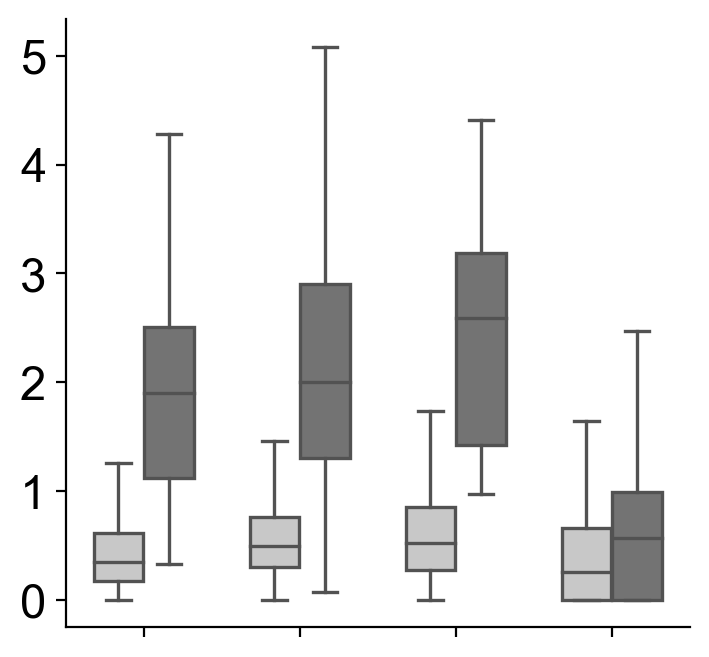

In [14]:
#pl.figure(figsize = (3,3))
line_color = '#525252'
line_thickness = 1.2
sn.boxplot(data = tidydata1, x='Dataset', y = 'Expression', 
           hue = 'Cell state', 
            hue_order = ['Rest','Aberrant'],
           boxprops=dict(linestyle='-', linewidth=line_thickness, edgecolor=line_color),
            whiskerprops=dict(linestyle='-', linewidth=line_thickness, color=line_color),
            capprops=dict(linestyle='-', linewidth=line_thickness, color=line_color),
            flierprops=dict(markeredgecolor=line_color, markerfacecolor='white', marker='o'),
            medianprops=dict(linestyle='-', linewidth=line_thickness, color=line_color),
           palette = {'Aberrant':'#737373', 'Rest':'#C8C8C8'},

          showfliers = False, width=0.65)



pl.grid(False)
sn.despine()
pl.legend([],[], frameon=False)

pl.xticks([0,1,2,3],labels = [], fontname = 'Arial')
pl.yticks([0,1,2,3,4,5],labels = [0,1,2,3,4,5], fontname = 'Arial', fontsize = 17)
pl.xlabel(None)
pl.ylabel(None)

pl.savefig("../../figures/Fig5E_aberrant_vs_rest1.pdf", bbox_inches='tight', dpi = 300)


## TGFB2

In [15]:
tidydata2 = pd.DataFrame(np.hstack([np.vstack([ipf1_aberrant_exp2, 
                                               'IPF1'*np.ones(ipf1_aberrant_exp2.shape[0],dtype = object),
                                               'Aberrant'*np.ones(ipf1_aberrant_exp2.shape[0], dtype =object)]),
                                    np.vstack([ipf1_rest_exp2, 
                                               'IPF1'*np.ones(ipf1_rest_exp2.shape[0],dtype = object),
                                               'Rest'*np.ones(ipf1_rest_exp2.shape[0], dtype =object)]),
           
                                    np.vstack([ipf2_aberrant_exp2, 
                                               'IPF2'*np.ones(ipf2_aberrant_exp2.shape[0],dtype = object),
                                               'Aberrant'*np.ones(ipf2_aberrant_exp2.shape[0], dtype =object)]),
                                    np.vstack([ipf2_rest_exp2, 
                                               'IPF2'*np.ones(ipf2_rest_exp2.shape[0],dtype = object),
                                               'Rest'*np.ones(ipf2_rest_exp2.shape[0], dtype =object)]),
                                    
                                    np.vstack([copd_aberrant_exp2, 
                                               'COPD'*np.ones(copd_aberrant_exp2.shape[0],dtype = object),
                                               'Aberrant'*np.ones(copd_aberrant_exp2.shape[0], dtype =object)]),
                                    np.vstack([copd_rest_exp2, 
                                               'COPD'*np.ones(copd_rest_exp2.shape[0],dtype = object),
                                               'Rest'*np.ones(copd_rest_exp2.shape[0], dtype =object)]),
                                    
                                    np.vstack([covid_aberrant_exp2, 
                                               'Covid'*np.ones(covid_aberrant_exp2.shape[0],dtype = object),
                                               'Aberrant'*np.ones(covid_aberrant_exp2.shape[0], dtype =object)]),
                                    np.vstack([covid_rest_exp2, 
                                               'Covid'*np.ones(covid_rest_exp2.shape[0],dtype = object),
                                               'Rest'*np.ones(covid_rest_exp2.shape[0], dtype =object)]),
                                   ])).T

tidydata2.columns = ['Expression', 'Dataset', 'Cell state']

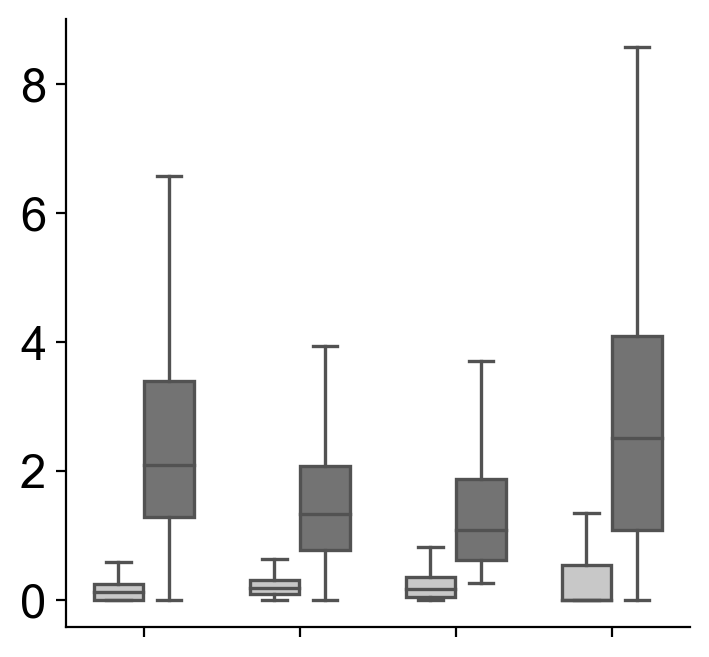

In [16]:
#pl.figure(figsize = (3,3))
line_color = '#525252'
sn.boxplot(data = tidydata2, x='Dataset', y = 'Expression', 
           hue = 'Cell state', 
            hue_order = ['Rest','Aberrant'],
           boxprops=dict(linestyle='-', linewidth=line_thickness, edgecolor=line_color),
            whiskerprops=dict(linestyle='-', linewidth=line_thickness, color=line_color),
            capprops=dict(linestyle='-', linewidth=line_thickness, color=line_color),
            flierprops=dict(markeredgecolor=line_color, markerfacecolor='white', marker='o'),
            medianprops=dict(linestyle='-', linewidth=line_thickness, color=line_color),
           palette = {'Aberrant':'#737373', 'Rest':'#C8C8C8'},

          showfliers = False, width=0.65)



pl.grid(False)
sn.despine()
pl.legend([],[], frameon=False)

pl.xticks([0,1,2,3],labels = [], fontname = 'Arial')
pl.yticks([0,2,4,6,8],labels = [0,2,4,6,8], fontname = 'Arial', fontsize = 17)
pl.xlabel(None)
pl.ylabel(None)

pl.savefig("../../figures/Fig5E_aberrant_vs_rest2.pdf", bbox_inches='tight', dpi = 300)
